## Fine tune sentence transformer model for text similarity

### Goal
- Build evaluation pipeline
- Evaluate the existing model
- Fine tune the model - see script: fine-tune_ddp.py
- Evaluate the fine tuned model
- Compare the results

### Install dependencies


In [ ]:
%pip install sentence-transformers matplotlib transformers

## Evaluation of Origin BGE Model

### 1. Download and Prepare the Dataset 

In [1]:
import os

from datasets import load_dataset

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

ds = load_dataset("JianLiao/spectrum-design-docs", split="train")

queries = {}
corpus = {}
relevant_docs = {}

for idx, row in enumerate(ds):
    # Setup unique query_id and doc_id
    query_id = f"q{idx+1}"
    doc_id = f"d{idx+1}"
    
    # Populate dictionaries
    queries[query_id] = row["anchor"]
    corpus[doc_id] = row["positive"]
    
    # Only one relevant document per query
    relevant_docs[query_id] = {doc_id} # Change to [] if multiple relevant documents

### 2. Evaluate baseline using InformationRetrievalEvaluator

In [2]:
from sentence_transformers import SentenceTransformer
from sentence_transformers.evaluation import InformationRetrievalEvaluator
from sentence_transformers.util import cos_sim

# Load the model
embedding_model = SentenceTransformer(
    model_name_or_path="BAAI/bge-large-en-v1.5",
    prompts={
        "anchor": "Represent this sentence for searching relevant passages: "
    })

evaluator = InformationRetrievalEvaluator(
    queries=queries,
    corpus=corpus,
    relevant_docs=relevant_docs,
    name=f"sds-docs",
    truncate_dim=1024,
    score_functions={"cosine": cos_sim},
)

results = evaluator(model=embedding_model)

### 3. Evaluate fine-tuned model using InformationRetrievalEvaluator 

In [3]:
from sentence_transformers import SentenceTransformer
from sentence_transformers.evaluation import InformationRetrievalEvaluator
from sentence_transformers.util import cos_sim

# Load the fine-tuned model
ft_embedding_model = SentenceTransformer(
    model_name_or_path="./ft_86_Epoch",
    prompts={
        "anchor": "Represent this sentence for searching relevant passages: "
    })

evaluator = InformationRetrievalEvaluator(
    queries=queries,
    corpus=corpus,
    relevant_docs=relevant_docs,
    name=f"sds-docs",
    truncate_dim=1024,
    score_functions={"cosine": cos_sim},
)

ft_results = evaluator(model=ft_embedding_model)

### 3. Show the Results

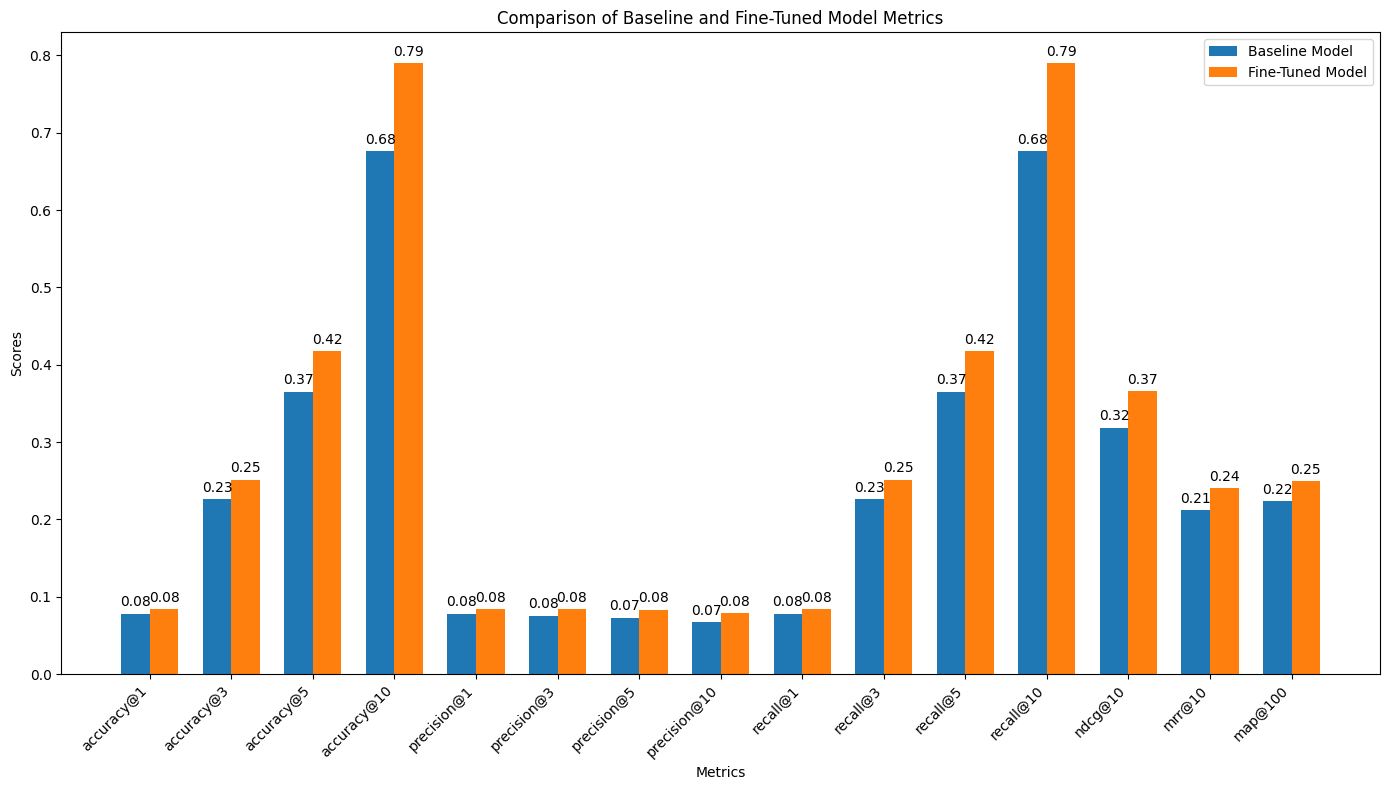

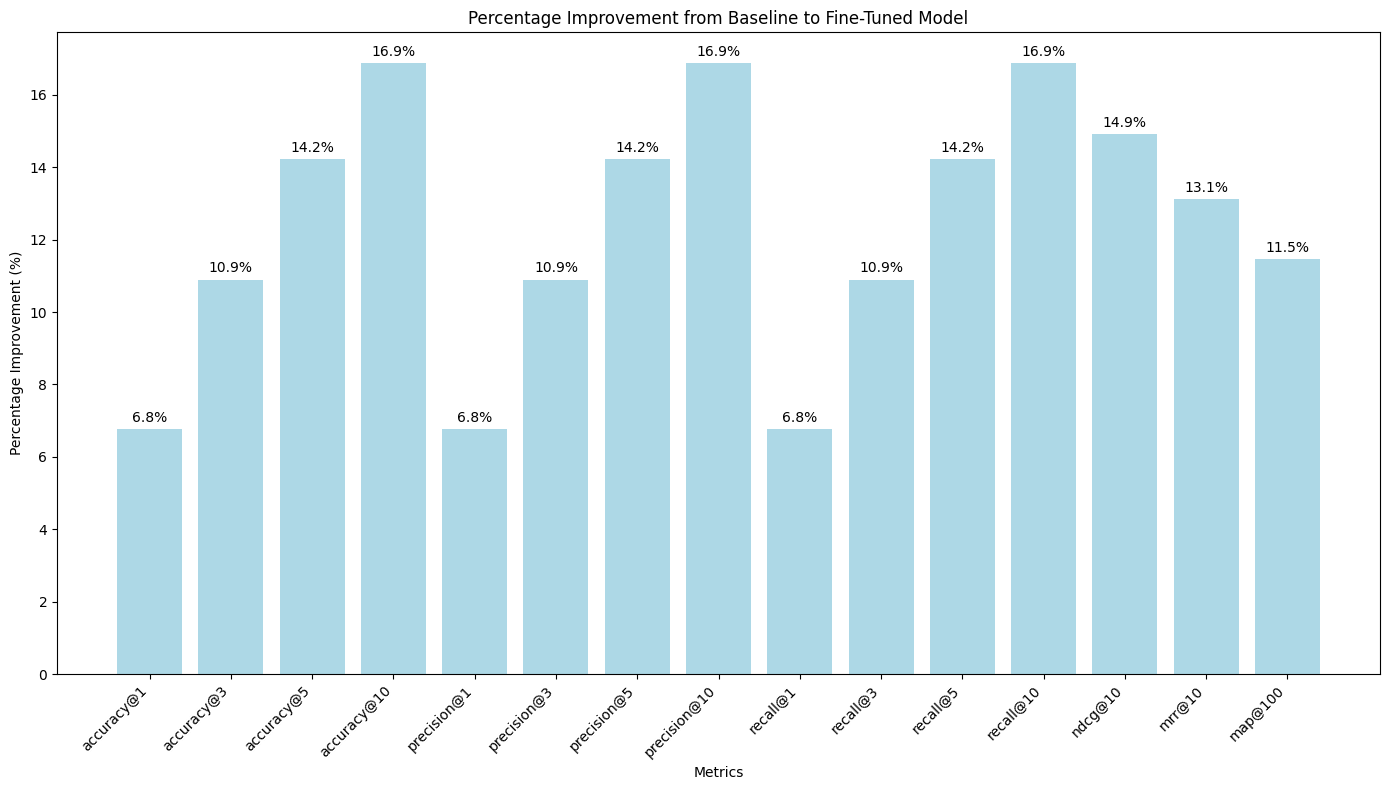

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# print(json.dumps(results, indent=4))
# print(json.dumps(ft_results, indent=4))

res = [results, ft_results]

# Extracting metrics and corresponding values
metrics = [
    "accuracy@1", "accuracy@3", "accuracy@5", "accuracy@10",
    "precision@1", "precision@3", "precision@5", "precision@10",
    "recall@1", "recall@3", "recall@5", "recall@10",
    "ndcg@10", "mrr@10", "map@100"
]

baseline_values = [res[0][f"sds-docs_cosine_{metric}"] for metric in metrics]
fine_tuned_values = [res[1][f"sds-docs_cosine_{metric}"] for metric in metrics]

# Plotting the results
x = np.arange(len(metrics))  # X-axis positions
width = 0.35  # Bar width

fig, ax = plt.subplots(figsize=(14, 8))

# Baseline and fine-tuned bars
baseline_bars = ax.bar(x - width / 2, baseline_values, width, label="Baseline Model")
fine_tuned_bars = ax.bar(x + width / 2, fine_tuned_values, width, label="Fine-Tuned Model")

# Adding labels, title, and legend
ax.set_xlabel("Metrics")
ax.set_ylabel("Scores")
ax.set_title("Comparison of Baseline and Fine-Tuned Model Metrics")
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=45, ha="right")
ax.legend()

# Annotating bars with values
for bars in [baseline_bars, fine_tuned_bars]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f"{height:.2f}", 
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Offset above the bar
                    textcoords="offset points",
                    ha="center", va="bottom")

plt.tight_layout()
plt.show()

# Calculate percentage improvements
percentage_improvements = [
    ((fine - base) / base * 100 if base > 0 else 0)
    for base, fine in zip(baseline_values, fine_tuned_values)
]

# Plotting percentage improvements
x = np.arange(len(metrics))  # X-axis positions
fig, ax = plt.subplots(figsize=(14, 8))

# Bar chart for percentage improvements
bars = ax.bar(x, percentage_improvements, color='lightblue')

# Adding labels, title, and legend
ax.set_xlabel("Metrics")
ax.set_ylabel("Percentage Improvement (%)")
ax.set_title("Percentage Improvement from Baseline to Fine-Tuned Model")
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=45, ha="right")

# Annotating bars with percentage values
for bar in bars:
    height = bar.get_height()
    ax.annotate(f"{height:.1f}%", 
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # Offset above the bar
                textcoords="offset points",
                ha="center", va="bottom")

plt.tight_layout()
plt.show()

### Accuracy@1
**Definition:**

Accuracy@1 measures how often the top result predicted by the model is correct (relevant to the query).

**Formula:**
$$Accuracy@1=\frac{Number of queries with correct result at rank 1}{Total number of queries}$$

### Accuracy@3
**Definition:**

Accuracy@3 measures how often at least one of the top 3 results predicted by the model is correct (relevant to the query).

**Formula:**
$$Accuracy@3=\frac{Number of queries with at least one correct result in top 3}{Total number of queries}$$

### Accuracy@5 Accuracy@10


### Precision@1

**Definition:**

Precision@1 measures the fraction of the top one results returned by the model that are relevant. It is essentially the same as Accuracy@1 when we evaluate precision for a single result.

**Formula:**
$$Precision@1=\frac{Number of relevant positives in top one}{Total number of queries}$$

### Precision@3 Precision@5 Precision@10

### Recall@1

**Definition:**

Recall@1 measures the fraction of all relevant documents that appear in the top-1 results. It focuses on how well the model retrieves relevant documents relative to the total number of relevant documents.

**Formula:**
$$Recall@1=\frac{Number of relevant positives in top one}{Total number of relevant documents}$$

### Recall@3 Recall@5 Recall@10

### nDCG@10

**Definition:**

Normalized Discounted Cumulative Gain (nDCG@10) measures the ranking quality of the top 10 results by considering the order of relevance. It emphasizes highly relevant results that appear earlier in the ranked list.

**Formula:**
$$DCG@10=\sum_{i=1}^{10}\frac{Relevance of document at rank i
}{\log_2(i+1)}$$

Ideal DCG (IDCG@10): The DCG when documents are perfectly ranked by relevance.

$$nDCG@10=\frac{DCG@10}{IDCG@10}$$

### MRR@10

**Definition:**

Mean Reciprocal Rank (MRR@10) measures the average reciprocal rank of the first relevant document within the top 10 results for all queries. It focuses on how early the first relevant document appears in the ranked list.

**Formula:**

$$MRR@10=\frac{1}{10}\sum_{i=1}^{10}\frac{1}{Rank of the first relevant document}$$

### M AP@100

**Definition:**

Mean Average Precision (MAP@100) measures the average precision of the top 100 results for multiple queries and then averages it across all queries. It accounts for both the relevance and ranking of documents.

**Formula:**

1. Compute the Precision@k for each relevant document at rank 𝑘 for a query:

$$Precision@k=\frac{Number of relevant documents in top-k}{k}$$

2. Compute the Average Precision (AP) for each query:

$$AP = \frac{\sum_{k=1}{100}Precision@k\times{Relevance@k}}{Total number of relevant documents for the query}$$

3. Compute the Mean Average Precision (MAP) across all queries:

$$ M AP@100 = \frac{1}{N}\sum_{i=1}{N} AP_i $$ 

where N is the total number of queries.